In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
import seawater as sw
import gsw
import xgcm
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#print(cluster.job_script())
#print(cluster.job_header)
w = cluster.scale(17)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [5]:
client

<Client: 'tcp://10.148.1.2:50831' processes=17 threads=119, memory=2.04 TB>

________________
### Readme: 
In this notebook, some basic information (e.g., bathymetry of the model domain, record-mean/max/min mixed layer depth, snapshots of u,v,w,b) are given in section 2. 

Section 3 displays some estimates based on the model output such as Rossby number, lateral buoyancy gradient, PV, Frontogenesis function. 

Raw outputs and 1-day low-pass filtered data are used in Section 3.

_________
# 1. Read dataset



In [6]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_zarr+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_zarr+'V_total_rechunk.zarr')
ds_W = xr.open_zarr(out_dir_zarr+'W_total_rechunk.zarr')
ds_D = xr.open_zarr(out_dir_zarr+'Pden_total_rechunk.zarr')
ds_MLD = xr.open_zarr(out_dir_zarr+'mld_filter.zarr')

# buoyancy
ds_B = -9.81*(ds_D.Pden-25)/1025
ds_B = np.real(ds_B).rename('Buoy')
ds_B = ds_B.to_dataset()

ds = xr.merge([ds_U,ds_V,ds_W,ds_B,ds_D,ds_MLD,grid])
ds = generate_grid_ds(ds, {'Z':'depth'})
print(ds)

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    XC          (lat, lon) float32 ...
    YC          (lat, lon) float32 ...
    XG          (lat_g, lon_g) float32 ...
    YG          (lat_g, lon_g) float32 ...
    CS          (lat, lon) float32 ...
    SN          (lat, lon) float32 ...
    Depth       (lat, lon) float32 ...
    dxC         (lat, lon_g) float32 ...
    dyC         (lat_g, lon) float32 ...
    dxG         (lat_g, lon) float32 .

In [7]:
grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)

ds_KPP = xr.open_zarr(out_dir_zarr+'KPPhbl_total_rechunk.zarr')
ds_Eta = xr.open_zarr(out_dir_zarr+'Eta_total_rechunk.zarr')
ds_taux = xr.open_zarr(out_dir_zarr+'oceTAUX_total_rechunk.zarr')
ds_tauy = xr.open_zarr(out_dir_zarr+'oceTAUY_total_rechunk.zarr')
ds_fwflx = xr.open_zarr(out_dir_zarr+'oceFWflx_total_rechunk.zarr')
ds_qnet = xr.open_zarr(out_dir_zarr+'oceQnet_total_rechunk.zarr')
ds_qsw = xr.open_zarr(out_dir_zarr+'oceQsw_total_rechunk.zarr')
ds_sflux = xr.open_zarr(out_dir_zarr+'oceSflux_total_rechunk.zarr')

ds_surface = xr.merge([ds_KPP,ds_Eta,ds_taux,ds_tauy,ds_fwflx,ds_qnet,ds_qsw,ds_sflux,grid])

In [8]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'},
                              'Z':{'center':'depth', 'left':'depth_left'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic):
  * center   lon --> left
  * left     lon_g --> center
Y Axis (periodic):
  * center   lat --> left
  * left     lat_g --> center
Z Axis (not periodic):
  * center   depth --> left
  * left     depth_left --> center


In [9]:
# Calculate vertical distances located on the cellboundary
ds.coords['dzc'] = gridx.diff(ds.depth, 'Z', boundary='extrapolate')
# Calculate vertical distances located on the cellcenter
ds.coords['dzt'] = gridx.diff(ds.depth_left, 'Z', boundary='extrapolate')
ds

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    XC          (lat, lon) float32 ...
    YC          (lat, lon) float32 ...
    XG          (lat_g, lon_g) float32 ...
    YG          (lat_g, lon_g) float32 ...
    CS          (lat, lon) float32 ...
    SN          (lat, lon) float32 ...
    Depth       (lat, lon) float32 ...
    dxC         (lat, lon_g) float32 ...
    dyC         (lat_g, lon) float32 ...
    dxG         (lat_g, lon) float32 .

In [10]:
lat = ds['YG']
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))
f_i = gridx.interp(f,'X')
f_j = gridx.interp(f,'Y')
f_ij = gridx.interp(f_i,'Y')
f

<xarray.DataArray 'YG' (lat_g: 201, lon_g: 177)>
array([[0.00010747, 0.00010747, 0.00010747, ..., 0.00010747, 0.00010747,
        0.00010747],
       [0.00010749, 0.00010749, 0.00010749, ..., 0.00010749, 0.00010749,
        0.00010749],
       [0.00010751, 0.00010751, 0.00010751, ..., 0.00010751, 0.00010751,
        0.00010751],
       ...,
       [0.00011177, 0.00011177, 0.00011177, ..., 0.00011177, 0.00011177,
        0.00011177],
       [0.00011179, 0.00011179, 0.00011179, ..., 0.00011179, 0.00011179,
        0.00011179],
       [0.00011181, 0.00011181, 0.00011181, ..., 0.00011181, 0.00011181,
        0.00011181]], dtype=float32)
Coordinates:
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
    XG       (lat_g, lon_g) float32 ...
    YG       (lat_g, lon_g) float32 47.39811 47.39811 ... 49.981472 49.981472
    rAz      (lat_g, lon_g) float32 ...

In [11]:
out_dir_filter = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'
grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Grid.nc', decode_coords=True)

ds_U_lowpass = xr.open_zarr(out_dir_filter+'U_lowpass_filter_1day_rechunk.zarr')
ds_V_lowpass = xr.open_zarr(out_dir_filter+'V_lowpass_filter_1day_rechunk.zarr')
ds_W_lowpass = xr.open_zarr(out_dir_filter+'W_lowpass_filter_1day_rechunk.zarr')
ds_B_lowpass = xr.open_zarr(out_dir_filter+'B_lowpass_filter_1day_rechunk.zarr')

ds_filter = xr.merge([ds_U_lowpass,ds_V_lowpass,ds_W_lowpass,ds_B_lowpass,grid])
print(ds_filter)

<xarray.Dataset>
Dimensions:       (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
    dxC           (lat, lon_g) float32 1567.638 1567.638 ... 1489.2013 1489.2013
    dyG           (lat, lon_g) float32 1468.5818 1468.5818 ... 1403.369 1403.369
  * lat           (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon_g         (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
    rAw           (lat, lon_g) float32 2302204.5 2302204.5 ... 2089899.0
  * time          (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
    dxG           (lat_g, lon) float32 1567.8346 1567.8346 ... 1489.3967
    dyC           (lat_g, lon) float32 1468.746 1468.746 ... 1403.5306 1403.5306
  * lat_g         (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon           (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    rAs           (lat_g, 

# 2. Basics

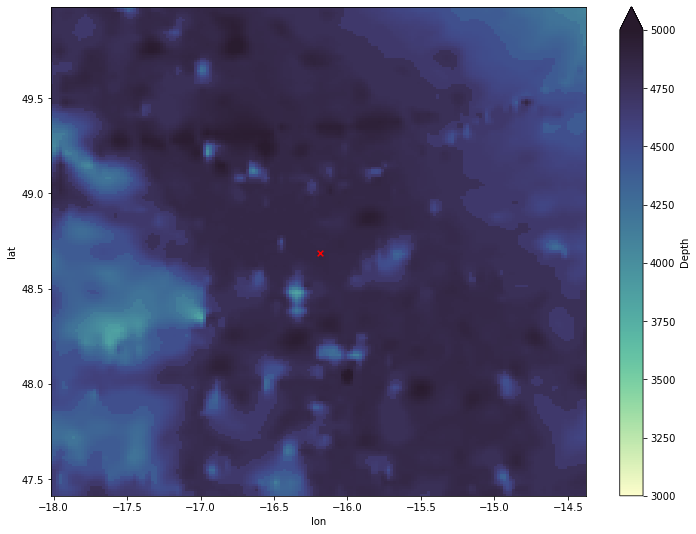

In [16]:
bathymetry = ds.Depth

fig = plt.figure(figsize=(12,9))
ax = plt.subplot(111)


bathymetry.isel(lat=slice(1,-1),lon=slice(1,-1)).plot(x='lon', y='lat', vmin=3000, vmax=5000, cmap=cm.deep)

ax.scatter(-16.1875,48.6875,s=32,marker='x',color='r')


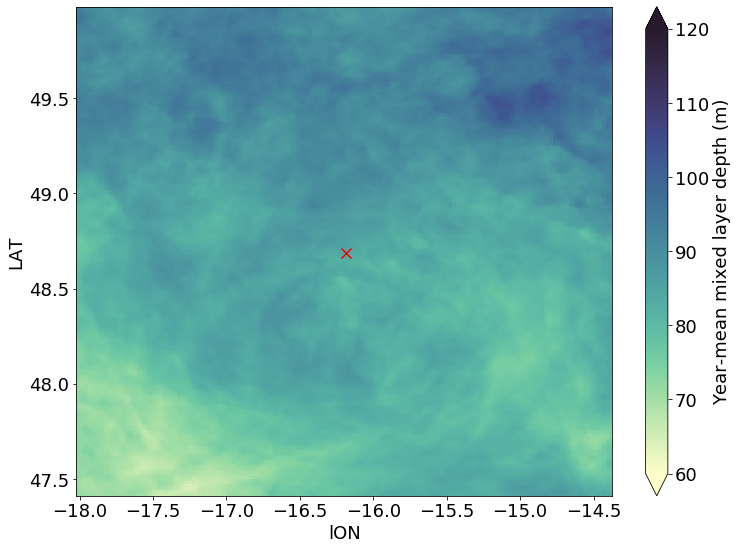

In [20]:
font_size = 18

fig = plt.figure(figsize=(12,9))
ax = plt.subplot(111)

cax=ds.mld_filter.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['time']).plot(x='lon', y='lat', vmin=60, vmax=120, cmap=cm.deep, add_colorbar = False)
ax.scatter(-16.1875,48.6875,s=100,marker='x',color='r')

cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Year-mean mixed layer depth (m)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('lON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/MLD_map.png')


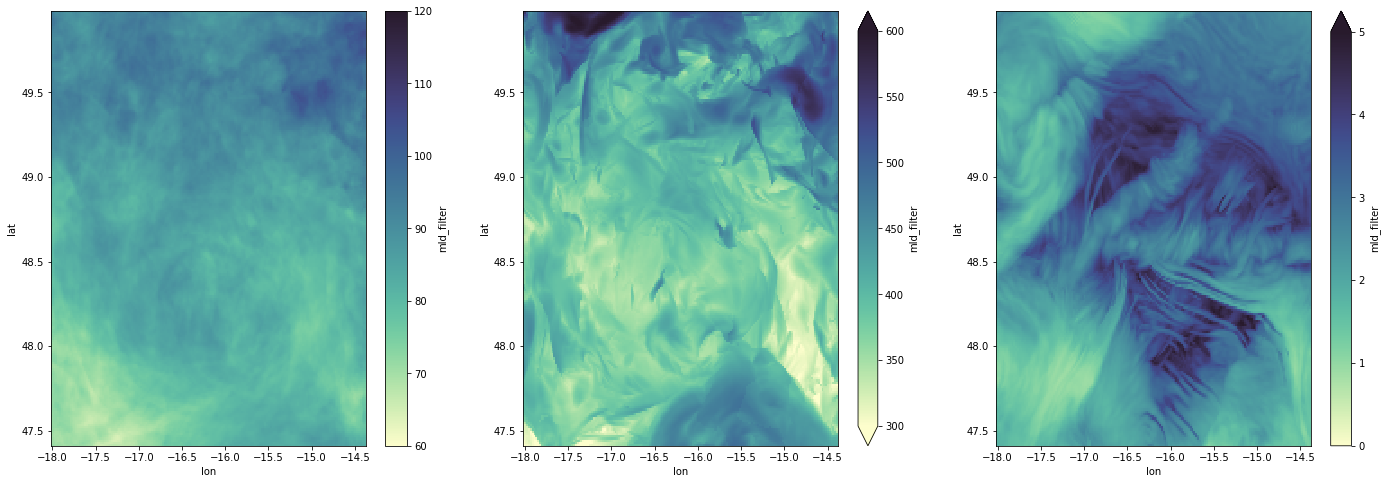

In [29]:
fig = plt.figure(figsize=(32,8))

plt.subplot(131)
ds.mld_filter.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['time']).plot(x='lon', y='lat', vmin=60, vmax=120, cmap=cm.deep)
plt.subplot(132)
ds.mld_filter.isel(lat=slice(1,-1),lon=slice(1,-1)).max(['time']).plot(x='lon', y='lat', vmin=300, vmax=600, cmap=cm.deep)
plt.subplot(133)
ds.mld_filter.isel(lat=slice(1,-1),lon=slice(1,-1)).min(['time']).plot(x='lon', y='lat', vmin=0, vmax=5, cmap=cm.deep)

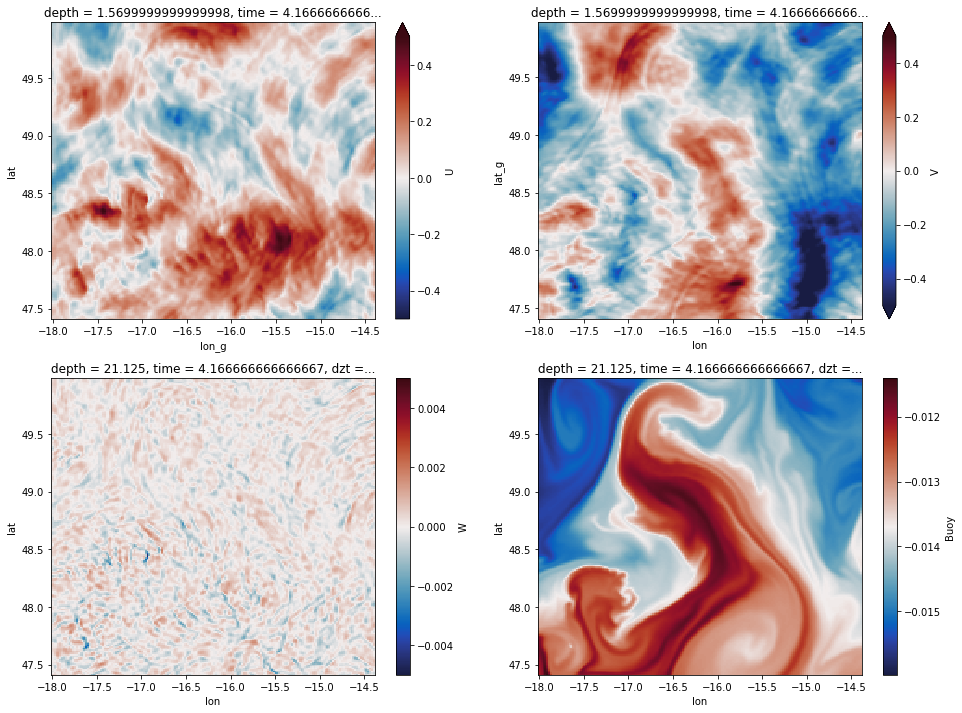

In [12]:
fig = plt.figure(figsize=(16,12))

plt.subplot(221)
ds.U.isel(lat=slice(1,-1),lon_g=slice(1,-1), time=100, depth=1).plot(x='lon_g', y='lat', vmin=-0.5, vmax=0.5, cmap=cm.balance)
plt.subplot(222)
ds.V.isel(lat_g=slice(1,-1),lon=slice(1,-1), time=100, depth=1).plot(x='lon', y='lat_g', vmin=-0.5, vmax=0.5, cmap=cm.balance)
plt.subplot(223)
ds.W.isel(lat=slice(1,-1),lon=slice(1,-1), time=100, depth=10).plot(x='lon', y='lat', vmin=-0.005, vmax=0.005, cmap=cm.balance)
plt.subplot(224)
ds.Buoy.isel(lat=slice(1,-1),lon=slice(1,-1), time=100, depth=10).plot(x='lon', y='lat', cmap=cm.balance)

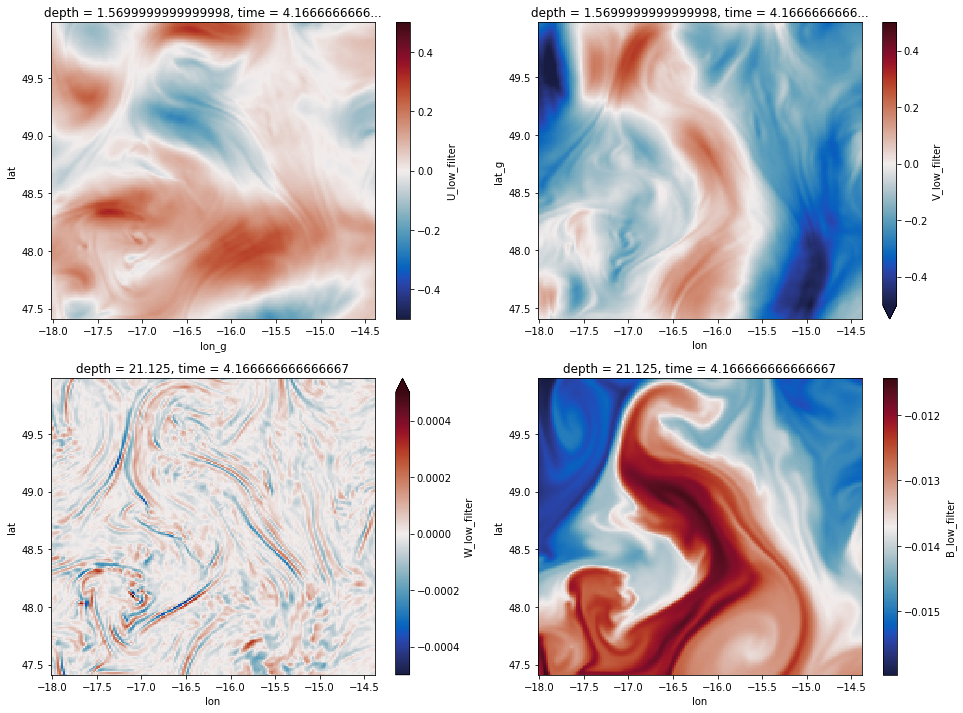

In [15]:
fig = plt.figure(figsize=(16,12))

plt.subplot(221)
ds_filter.U_low_filter.isel(lat=slice(1,-1),lon_g=slice(1,-1), time=100, depth=1).plot(x='lon_g', y='lat', vmin=-0.5, vmax=0.5, cmap=cm.balance)
plt.subplot(222)
ds_filter.V_low_filter.isel(lat_g=slice(1,-1),lon=slice(1,-1), time=100, depth=1).plot(x='lon', y='lat_g', vmin=-0.5, vmax=0.5, cmap=cm.balance)
plt.subplot(223)
ds_filter.W_low_filter.isel(lat=slice(1,-1),lon=slice(1,-1), time=100, depth=10).plot(x='lon', y='lat', vmin=-0.0005, vmax=0.0005, cmap=cm.balance)
plt.subplot(224)
ds_filter.B_low_filter.isel(lat=slice(1,-1),lon=slice(1,-1), time=100, depth=10).plot(x='lon', y='lat', cmap=cm.balance)

# 3. Parameter

## 3.1 Rossby number

In [16]:
zeta = (gridx.diff(ds.dyC*ds['V'],'X') - gridx.diff(ds.dxC * ds['U'],'Y'))/ds.rAz
zeta_f = (zeta/f)
zeta_f

<xarray.DataArray (lat_g: 201, lon_g: 177, time: 9415, depth: 52)>
dask.array<truediv, shape=(201, 177, 9415, 52), dtype=float32, chunksize=(200, 176, 9415, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
    XG       (lat_g, lon_g) float32 -18.041666 -18.020834 ... -14.395833 -14.375
    YG       (lat_g, lon_g) float32 47.39811 47.39811 ... 49.981472 49.981472
    rAz      (lat_g, lon_g) float32 2302750.8 2302750.8 ... 2090414.0 2090414.0

In [17]:
zeta_filter = (gridx.diff(ds_filter.dyC*ds_filter['V_low_filter'],'X') - gridx.diff(ds_filter.dxC * ds_filter['U_low_filter'],'Y'))/ds_filter.rAz
zeta_filter_f = (zeta_filter/f)
zeta_filter_f

<xarray.DataArray (lat_g: 201, lon_g: 177, time: 9415, depth: 52)>
dask.array<truediv, shape=(201, 177, 9415, 52), dtype=float32, chunksize=(200, 176, 9415, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
    XG       (lat_g, lon_g) float32 -18.041666 -18.020834 ... -14.395833 -14.375
    YG       (lat_g, lon_g) float32 47.39811 47.39811 ... 49.981472 49.981472
    rAz      (lat_g, lon_g) float32 2302750.8 2302750.8 ... 2090414.0 2090414.0

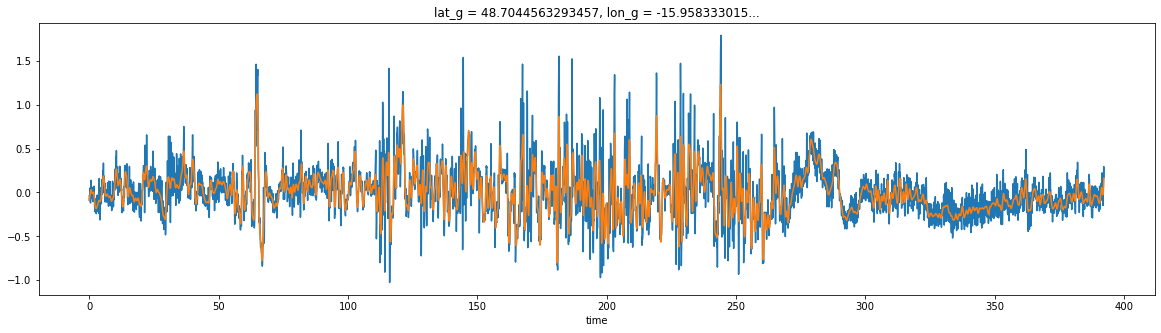

In [18]:
fig = plt.figure(figsize=(20,5))

zeta_f.isel(lat_g=100, lon_g=100,depth=1).plot()
zeta_filter_f.isel(lat_g=100, lon_g=100,depth=1).plot()

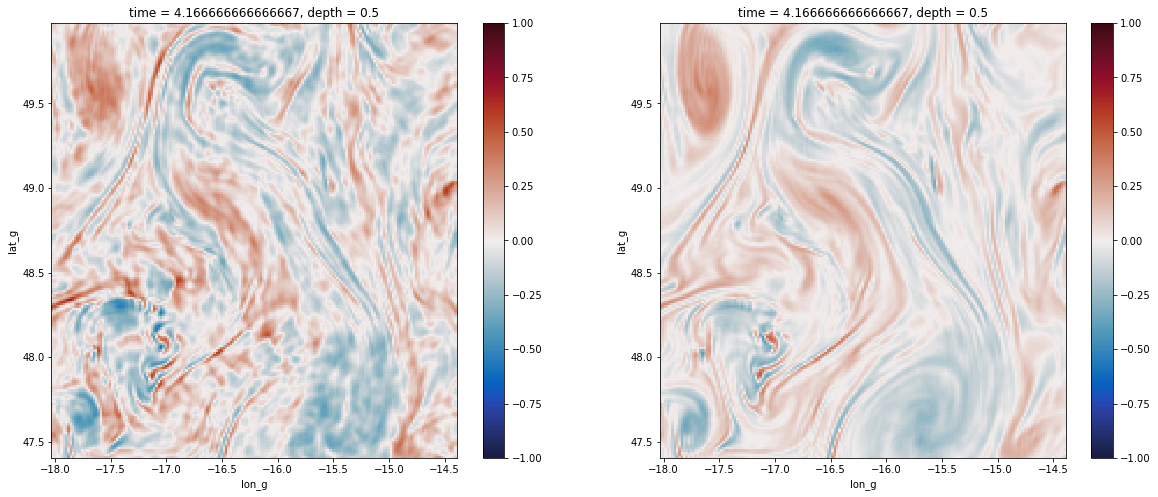

In [20]:
fig = plt.figure(figsize=(20,8))

plt.subplot(121)
zeta_f.isel(lat_g=slice(1,-1),lon_g=slice(1,-1),time=100,depth=0).plot(x='lon_g', y='lat_g', vmin=-1, vmax=1, cmap=cm.balance)
plt.subplot(122)
zeta_filter_f.isel(lat_g=slice(1,-1),lon_g=slice(1,-1),time=100,depth=0).plot(x='lon_g', y='lat_g', vmin=-1, vmax=1, cmap=cm.balance)

## 3.2 KE

In [22]:
KE = (gridx.interp(ds['U']**2,'X') + gridx.interp(ds['V']**2,'Y'))/2 # KE
KE

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<truediv, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 176), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [23]:
KE_filter = (gridx.interp(ds_filter['U_low_filter']**2,'X') + gridx.interp(ds_filter['V_low_filter']**2,'Y'))/2 # KE
KE_filter

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<truediv, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 176), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

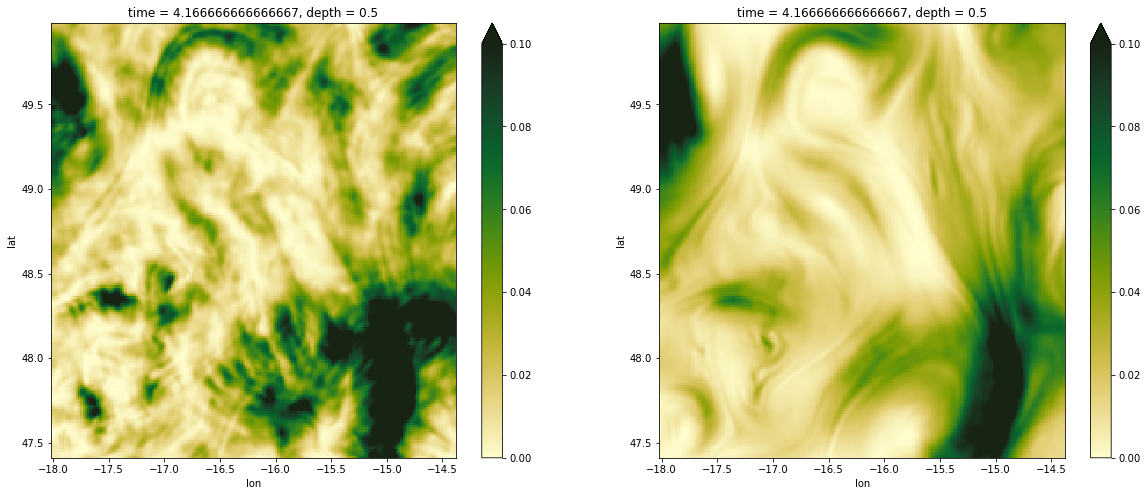

In [24]:
fig = plt.figure(figsize=(20,8))

plt.subplot(121)
KE.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=0).plot(x='lon', y='lat', vmin=0, vmax=0.1, cmap=cm.speed)
plt.subplot(122)
KE_filter.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=0).plot(x='lon', y='lat', vmin=0, vmax=0.1, cmap=cm.speed)

## 3.3 Horizontal strain

In [25]:
strain = (gridx.diff(ds['U'] * ds.dyG, 'X') - gridx.diff(ds['V']* ds.dxG, 'Y')) / ds.rA
strain_f = (strain/f_ij)
strain_f

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<truediv, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 176), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
    XC       (lat, lon) float32 ...
    YC       (lat, lon) float32 ...
    CS       (lat, lon) float32 ...
    SN       (lat, lon) float32 ...
    Depth    (lat, lon) float32 ...
    rA       (lat, lon) float32 ...

In [26]:
strain_filter = (gridx.diff(ds_filter['U_low_filter'] * ds.dyG, 'X') - gridx.diff(ds_filter['V_low_filter']* ds.dxG, 'Y')) / ds.rA
strain_f_filter = (strain_filter/f_ij)
strain_f_filter

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<truediv, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 176), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
    XC       (lat, lon) float32 ...
    YC       (lat, lon) float32 ...
    CS       (lat, lon) float32 ...
    SN       (lat, lon) float32 ...
    Depth    (lat, lon) float32 ...
    rA       (lat, lon) float32 ...

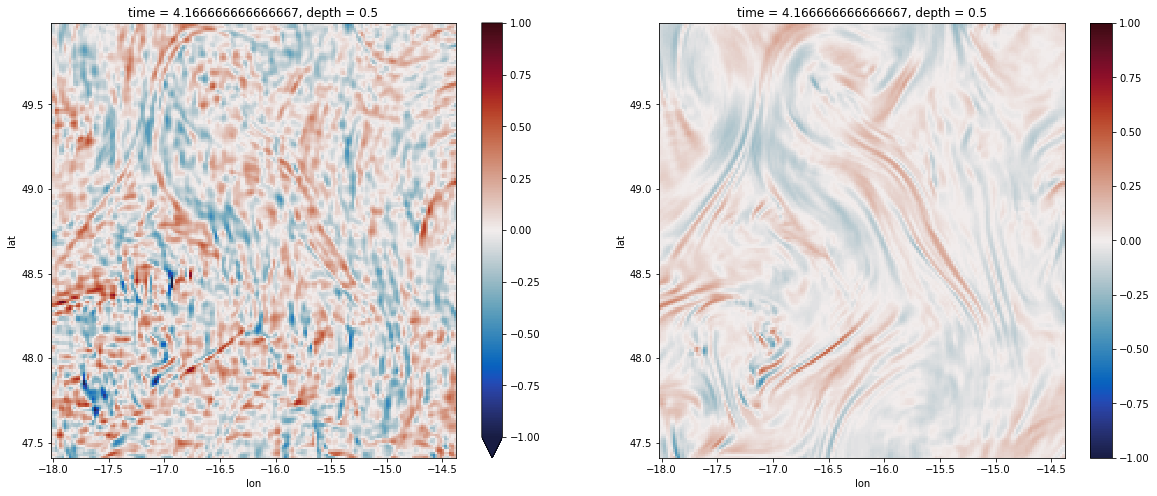

In [27]:
fig = plt.figure(figsize=(20,8))

plt.subplot(121)
strain_f.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=0).plot(x='lon', y='lat', vmin=-1., vmax=1., cmap=cm.balance)
plt.subplot(122)
strain_f_filter.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=0).plot(x='lon', y='lat', vmin=-1., vmax=1., cmap=cm.balance)

## 3.4 Horizontal divergence

In [28]:
vel_div_components = gridx.diff_2d_vector({'X': ds.dyG * ds['U'], 'Y': ds.dxG * ds['V']}, boundary='extend')
vel_div = (vel_div_components['X'] + vel_div_components['Y'])/ds.rA
vel_div_f = (vel_div/f_ij)
vel_div_f

<xarray.DataArray (lat: 201, lon: 177, time: 9415, depth: 52)>
dask.array<truediv, shape=(201, 177, 9415, 52), dtype=float32, chunksize=(200, 176, 9415, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
    XC       (lat, lon) float32 ...
    YC       (lat, lon) float32 ...
    CS       (lat, lon) float32 ...
    SN       (lat, lon) float32 ...
    Depth    (lat, lon) float32 ...
    rA       (lat, lon) float32 ...

In [29]:
vel_div_components_filter = gridx.diff_2d_vector({'X': ds.dyG * ds_filter['U_low_filter'], 'Y': ds.dxG * ds_filter['V_low_filter']}, boundary='extend')
vel_div_filter = (vel_div_components_filter['X'] + vel_div_components_filter['Y'])/ds.rA
vel_div_f_filter = (vel_div_filter/f_ij)
vel_div_f_filter

<xarray.DataArray (lat: 201, lon: 177, time: 9415, depth: 52)>
dask.array<truediv, shape=(201, 177, 9415, 52), dtype=float32, chunksize=(200, 176, 9415, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
    XC       (lat, lon) float32 ...
    YC       (lat, lon) float32 ...
    CS       (lat, lon) float32 ...
    SN       (lat, lon) float32 ...
    Depth    (lat, lon) float32 ...
    rA       (lat, lon) float32 ...

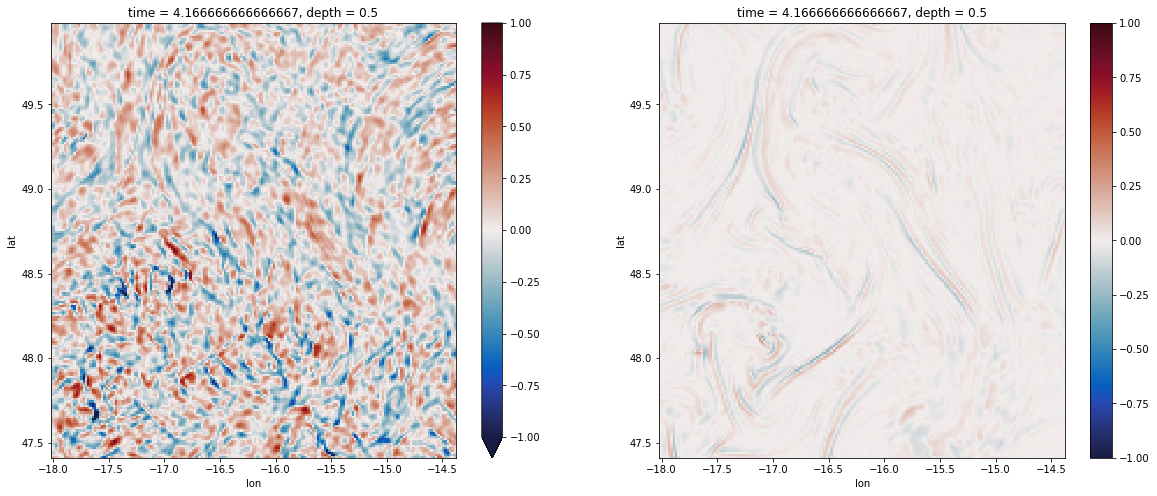

In [30]:
fig = plt.figure(figsize=(20,8))

plt.subplot(121)
vel_div_f.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=0).plot(x='lon', y='lat', vmin=-1., vmax=1., cmap=cm.balance)
plt.subplot(122)
vel_div_f_filter.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=0).plot(x='lon', y='lat', vmin=-1., vmax=1., cmap=cm.balance)

## 3.5 lateral gradient

In [31]:
db_dx = gridx.diff(ds['Buoy'],'X')/ds.dxC     # db/dx
db_dx_ij = gridx.interp(db_dx,'X')
db_dy = gridx.diff(ds['Buoy'],'Y')/ds.dyC     # db/dy
db_dy_ij = gridx.interp(db_dy,'Y')

lateral_buoyancy_gradient = np.sqrt(db_dx_ij*db_dx_ij + db_dy_ij*db_dy_ij)
print(lateral_buoyancy_gradient)

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<sqrt, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 199, 175), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36


In [32]:
db_dx_filter = gridx.diff(ds_filter['B_low_filter'],'X')/ds.dxC     # db/dx
db_dx_ij_filter = gridx.interp(db_dx_filter,'X')
db_dy_filter = gridx.diff(ds_filter['B_low_filter'],'Y')/ds.dyC     # db/dy
db_dy_ij_filter = gridx.interp(db_dy_filter,'Y')

lateral_buoyancy_gradient_filter = np.sqrt(db_dx_ij_filter*db_dx_ij_filter + db_dy_ij_filter*db_dy_ij_filter)
print(lateral_buoyancy_gradient_filter)

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<sqrt, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 199, 175), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36


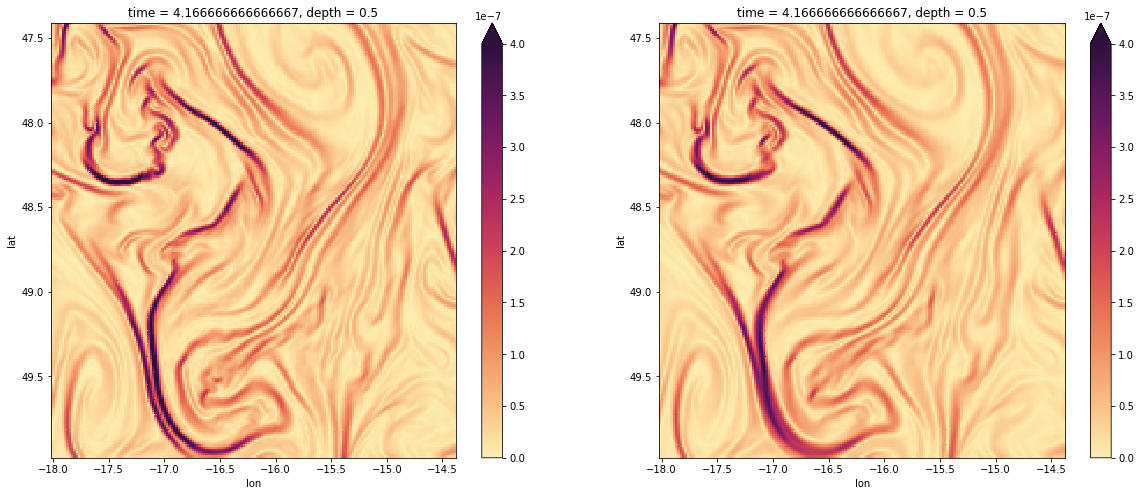

In [33]:
fig = plt.figure(figsize=(20,8))

plt.subplot(121)
lateral_buoyancy_gradient.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=0).plot(x='lon', y='lat', vmin=0, vmax=4e-7,cmap=cm.matter, yincrease=False)
plt.subplot(122)
lateral_buoyancy_gradient_filter.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=0).plot(x='lon', y='lat', vmin=0, vmax=4e-7,cmap=cm.matter, yincrease=False)

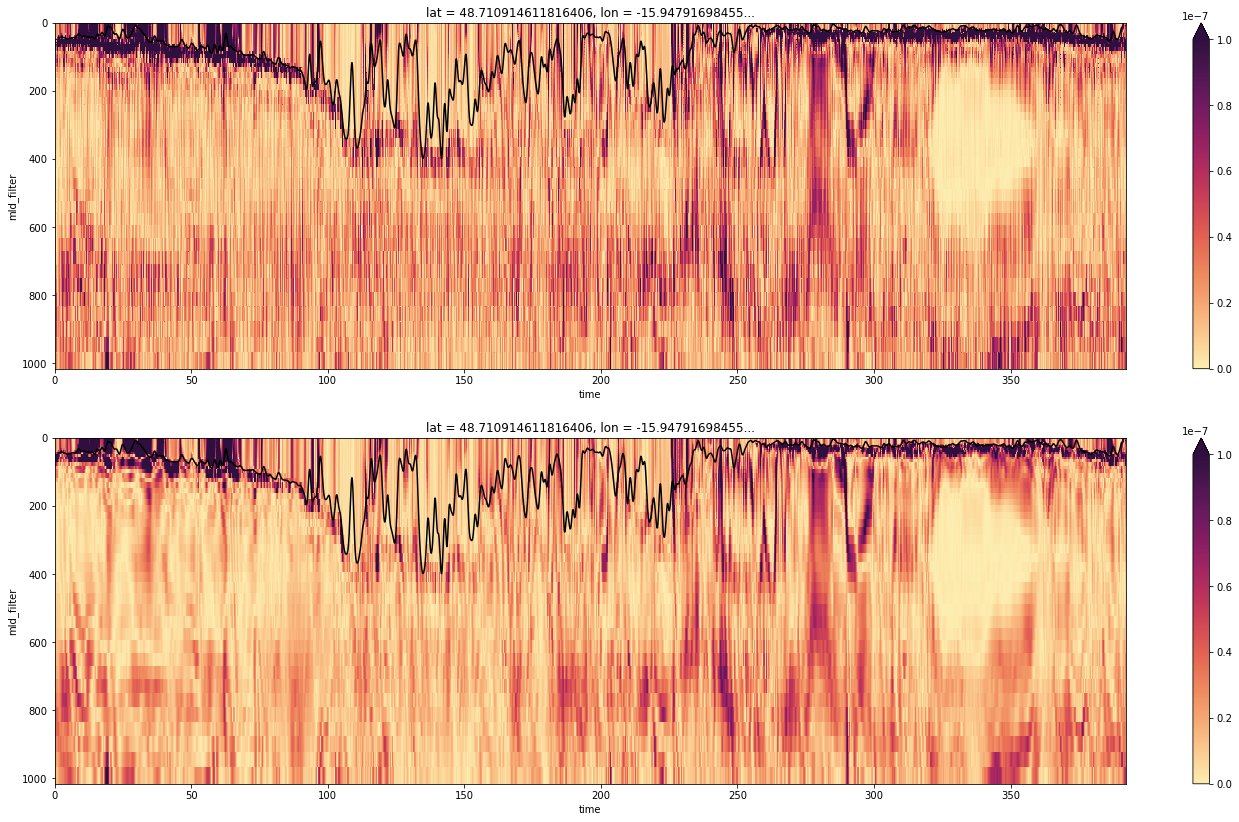

In [34]:
fig = plt.figure(figsize=(24,14))

plt.subplot(211)
lateral_buoyancy_gradient.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=0,vmax=1e-7,cmap=cm.matter, yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

plt.subplot(212)
lateral_buoyancy_gradient_filter.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=0,vmax=1e-7,cmap=cm.matter, yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

## 3.6 PV

In [35]:
zeta = (gridx.diff(ds.dyC*ds['V'],'X') - gridx.diff(ds.dxC * ds['U'],'Y'))/ds.rAz
zeta_i =  gridx.interp(zeta,'X')
zeta_ij =  gridx.interp(zeta_i,'Y')

db_dz_left = -1*gridx.diff(ds.Buoy, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc  #### -1* is necessary to make the sign correct ####
db_dz = gridx.interp(db_dz_left,'Z', boundary='fill')
db_dz = db_dz.astype(np.float32)

PV = (f_ij + zeta_ij)*db_dz - (db_dx_ij**2 + db_dy_ij**2)/f_ij
chunks = {'time': 9415, 'lat': 201, 'lon': 177, 'depth':1}
PV = PV.chunk(chunks)
PV

<xarray.DataArray (lat: 201, lon: 177, time: 9415, depth: 52)>
dask.array<rechunk-merge, shape=(201, 177, 9415, 52), dtype=float32, chunksize=(201, 177, 9415, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

In [37]:
zeta_filter = (gridx.diff(ds_filter.dyC*ds_filter['V_low_filter'],'X') - gridx.diff(ds_filter.dxC * ds_filter['U_low_filter'],'Y'))/ds_filter.rAz
zeta_i_filter =  gridx.interp(zeta_filter,'X')
zeta_ij_filter =  gridx.interp(zeta_i_filter,'Y')

db_dz_left_filter = -1*gridx.diff(ds_filter.B_low_filter, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc  #### -1* is necessary to make the sign correct ####
db_dz_filter = gridx.interp(db_dz_left_filter,'Z', boundary='fill')
db_dz_filter = db_dz_filter.astype(np.float32)

PV_filter = (f_ij + zeta_ij_filter)*db_dz_filter - (db_dx_ij_filter**2 + db_dy_ij_filter**2)/f_ij
chunks = {'time': 9415, 'lat': 201, 'lon': 177, 'depth':1}
PV_filter = PV_filter.chunk(chunks)
PV_filter

<xarray.DataArray (lat: 201, lon: 177, time: 9415, depth: 52)>
dask.array<rechunk-merge, shape=(201, 177, 9415, 52), dtype=float32, chunksize=(201, 177, 9415, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

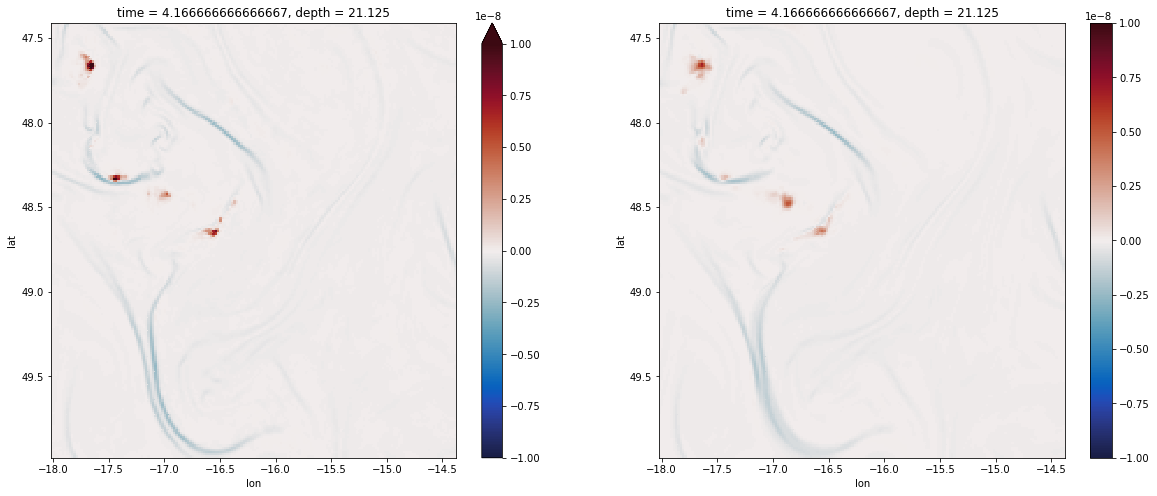

In [38]:
fig = plt.figure(figsize=(20,8))

plt.subplot(121)
PV.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=10).plot(x='lon', y='lat', vmin=-1e-8, vmax=1e-8,cmap=cm.balance, yincrease=False)
plt.subplot(122)
PV_filter.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=10).plot(x='lon', y='lat', vmin=-1e-8, vmax=1e-8,cmap=cm.balance, yincrease=False)

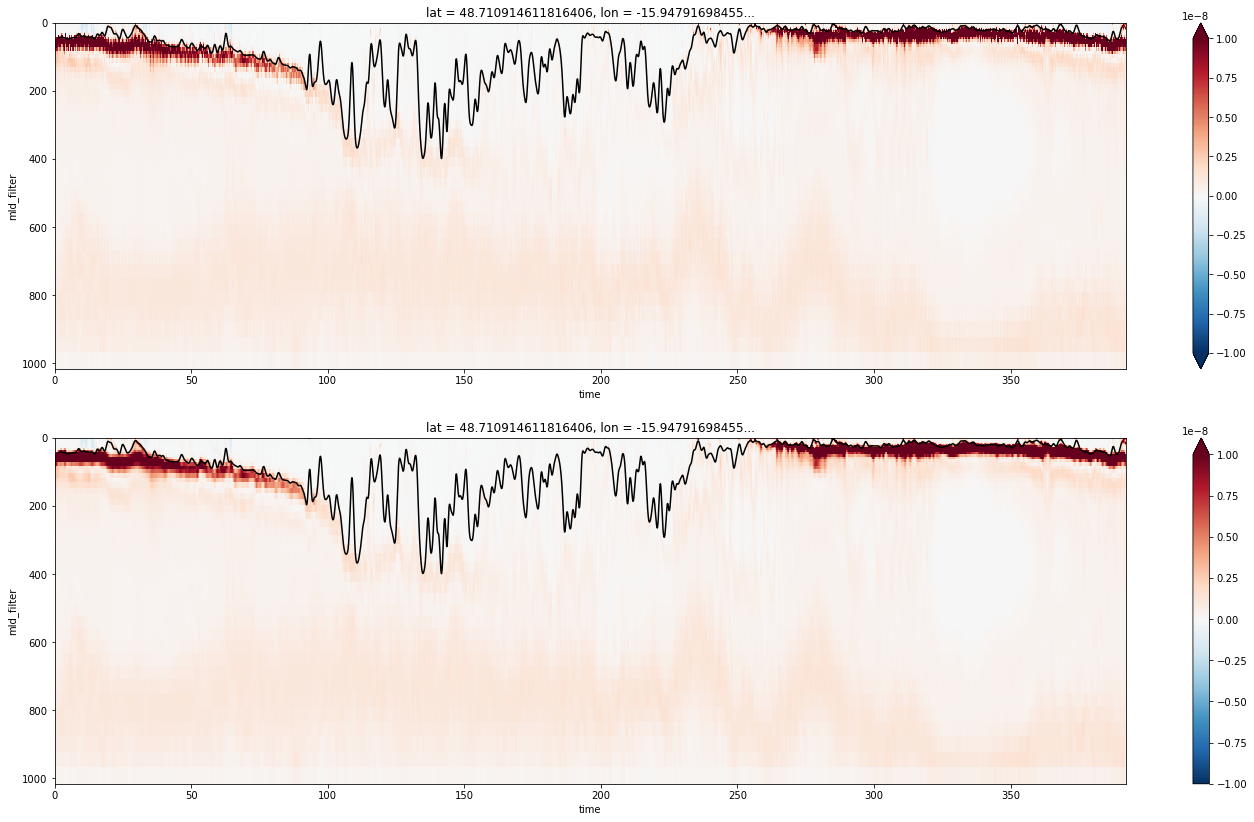

In [39]:
fig = plt.figure(figsize=(24,14))

plt.subplot(211)
PV.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-1e-8,vmax=1e-8,cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

plt.subplot(212)
PV_filter.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-1e-8,vmax=1e-8,cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

## 3.7 Richardson number

In [44]:
db_dz_left = -1*gridx.diff(ds.Buoy, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc  #### -1* is necessary to make the sign correct ####
db_dz = gridx.interp(db_dz_left,'Z', boundary='fill')
db_dz = db_dz.astype(np.float32)

dU_dz_left = -1*gridx.diff(ds.U, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dU_dz_1 = gridx.interp(dU_dz_left,'Z', boundary='fill')
dU_dz = gridx.interp(dU_dz_1,'X')
dU_dz = dU_dz.astype(np.float32)

dV_dz_left = -1*gridx.diff(ds.V, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dV_dz_1 = gridx.interp(dV_dz_left,'Z', boundary='fill')
dV_dz = gridx.interp(dV_dz_1,'Y')
dV_dz = dV_dz.astype(np.float32)

Ri = db_dz/(dU_dz**2 + dV_dz**2)
Ri

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<truediv, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 176), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [45]:
db_dz_left_filter = -1*gridx.diff(ds_filter.B_low_filter, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc  #### -1* is necessary to make the sign correct ####
db_dz_filter = gridx.interp(db_dz_left_filter,'Z', boundary='fill')
db_dz_filter = db_dz_filter.astype(np.float32)

dU_dz_left_filter = -1*gridx.diff(ds_filter.U_low_filter, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dU_dz_1_filter = gridx.interp(dU_dz_left_filter,'Z', boundary='fill')
dU_dz_filter = gridx.interp(dU_dz_1_filter,'X')
dU_dz_filter = dU_dz_filter.astype(np.float32)

dV_dz_left_filter = -1*gridx.diff(ds_filter.V_low_filter, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dV_dz_1_filter = gridx.interp(dV_dz_left_filter,'Z', boundary='fill')
dV_dz_filter = gridx.interp(dV_dz_1_filter,'Y')
dV_dz_filter = dV_dz_filter.astype(np.float32)

Ri_filter = db_dz_filter/(dU_dz_filter**2 + dV_dz_filter**2)
Ri_filter

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<truediv, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 176), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

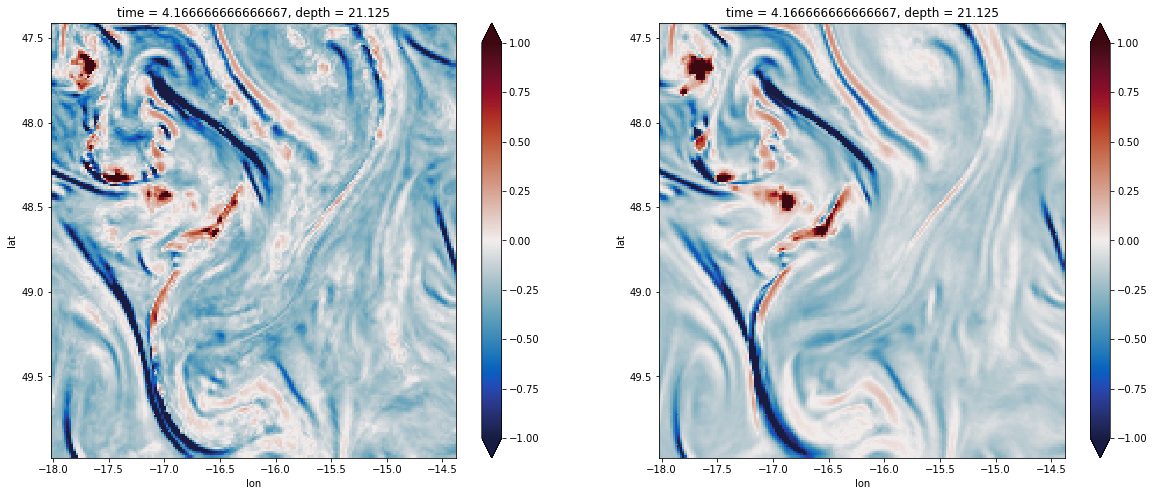

In [49]:
fig = plt.figure(figsize=(20,8))

plt.subplot(121)
Ri.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=10).plot(x='lon', y='lat', vmin=-1, vmax=1,cmap=cm.balance, yincrease=False)
plt.subplot(122)
Ri_filter.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=10).plot(x='lon', y='lat', vmin=-1, vmax=1,cmap=cm.balance, yincrease=False)

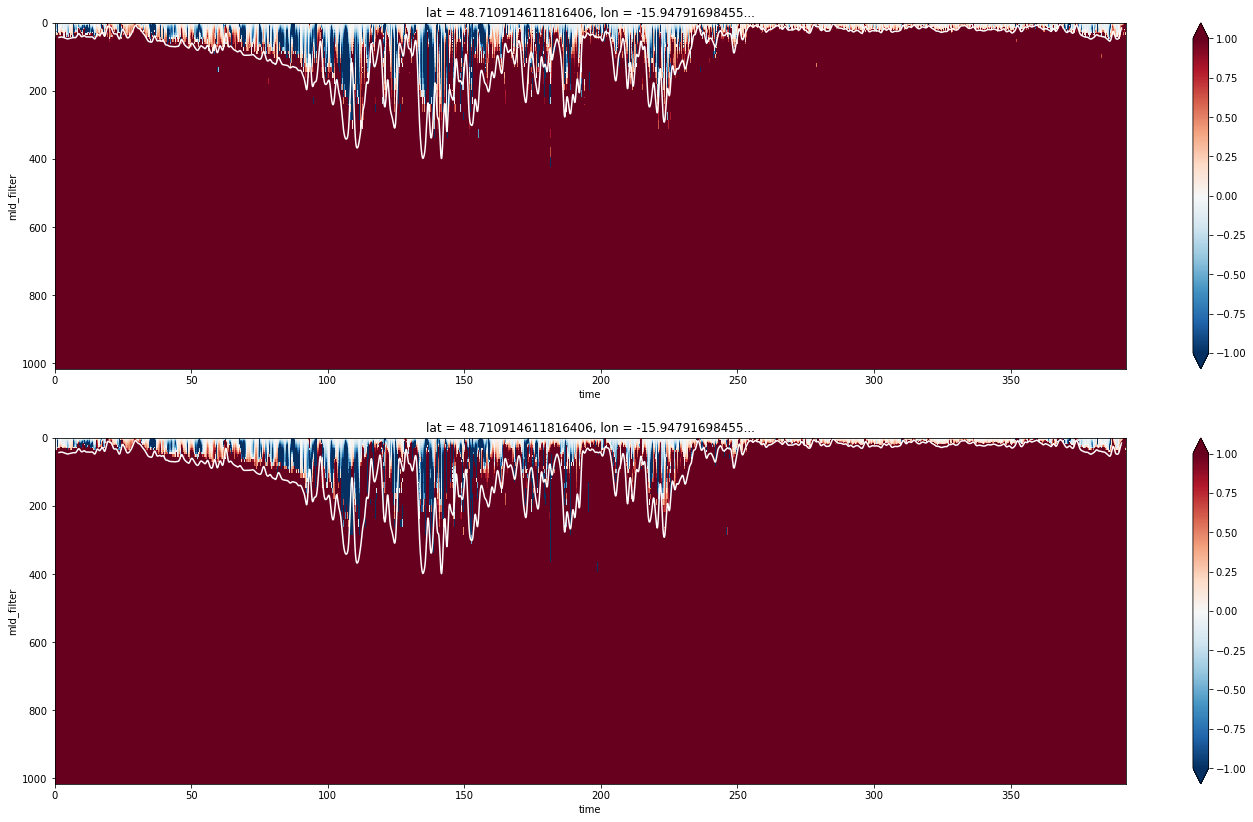

In [50]:
fig = plt.figure(figsize=(24,14))

plt.subplot(211)
Ri.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-1,vmax=1,cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='white', yincrease=False)

plt.subplot(212)
Ri_filter.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-1,vmax=1,cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='white', yincrease=False)

## 3.8 Frontogenesis function

In [40]:
db_dx = gridx.diff(ds['Buoy'],'X')/ds.dxC     # db/dx
db_dx_ij = gridx.interp(db_dx,'X')

db_dy = gridx.diff(ds['Buoy'],'Y')/ds.dyC     # db/dy
db_dy_ij = gridx.interp(db_dy,'Y')

du_dx_ij = gridx.diff(ds['U'], 'X')/gridx.interp(ds.dxG, 'Y')
du_dx_ij

dU_dy_1 = gridx.diff(ds['U'], 'Y')/gridx.interp(ds.dyC, 'X')
dU_dy_2 = gridx.interp(dU_dy_1, 'X')
du_dy_ij = gridx.interp(dU_dy_2, 'Y')
du_dy_ij

dV_dx_1 = gridx.diff(ds['V'], 'X')/gridx.interp(ds.dxC, 'Y')
dV_dx_2 = gridx.interp(dV_dx_1, 'X')
dv_dx_ij = gridx.interp(dV_dx_2, 'Y')
dv_dx_ij

dv_dy_ij = gridx.diff(ds['V'], 'Y')/gridx.interp(ds.dyG, 'X')
dv_dy_ij

Fs = -(du_dx_ij*db_dx_ij*db_dx_ij + dv_dx_ij*db_dx_ij*db_dy_ij + du_dy_ij*db_dx_ij*db_dy_ij + dv_dy_ij*db_dy_ij*db_dy_ij)

In [41]:
db_dx_filter = gridx.diff(ds_filter['B_low_filter'],'X')/ds.dxC     # db/dx
db_dx_ij_filter = gridx.interp(db_dx_filter,'X')

db_dy_filter = gridx.diff(ds_filter['B_low_filter'],'Y')/ds.dyC     # db/dy
db_dy_ij_filter = gridx.interp(db_dy_filter,'Y')

du_dx_ij_filter = gridx.diff(ds_filter['U_low_filter'], 'X')/gridx.interp(ds.dxG, 'Y')


dU_dy_1_filter = gridx.diff(ds_filter['U_low_filter'], 'Y')/gridx.interp(ds.dyC, 'X')
dU_dy_2_filter = gridx.interp(dU_dy_1_filter, 'X')
du_dy_ij_filter = gridx.interp(dU_dy_2_filter, 'Y')

dV_dx_1_filter = gridx.diff(ds_filter['V_low_filter'], 'X')/gridx.interp(ds.dxC, 'Y')
dV_dx_2_filter = gridx.interp(dV_dx_1_filter, 'X')
dv_dx_ij_filter = gridx.interp(dV_dx_2_filter, 'Y')

dv_dy_ij_filter = gridx.diff(ds_filter['V_low_filter'], 'Y')/gridx.interp(ds.dyG, 'X')
dv_dy_ij_filter

Fs_filter = -(du_dx_ij_filter*db_dx_ij_filter*db_dx_ij_filter + dv_dx_ij_filter*db_dx_ij_filter*db_dy_ij_filter + du_dy_ij_filter*db_dx_ij_filter*db_dy_ij_filter + dv_dy_ij_filter*db_dy_ij_filter*db_dy_ij_filter)
Fs_filter

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<neg, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 199, 175), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

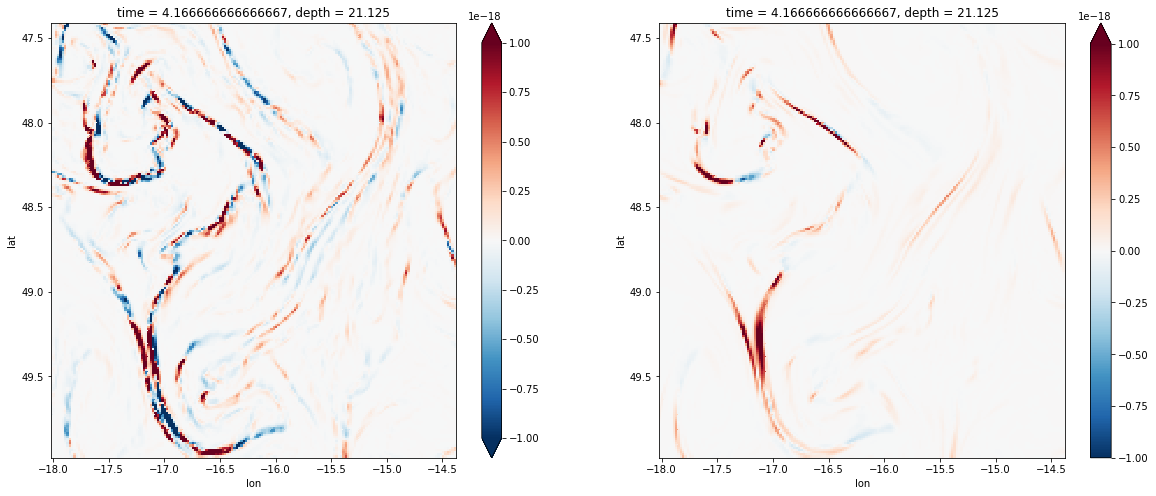

In [42]:
fig = plt.figure(figsize=(20,8))

plt.subplot(121)
Fs.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=10).plot(x='lon', y='lat', vmin=-1e-18, vmax=1e-18,cmap='RdBu_r', yincrease=False)
plt.subplot(122)
Fs_filter.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=10).plot(x='lon', y='lat', vmin=-1e-18, vmax=1e-18,cmap='RdBu_r', yincrease=False)

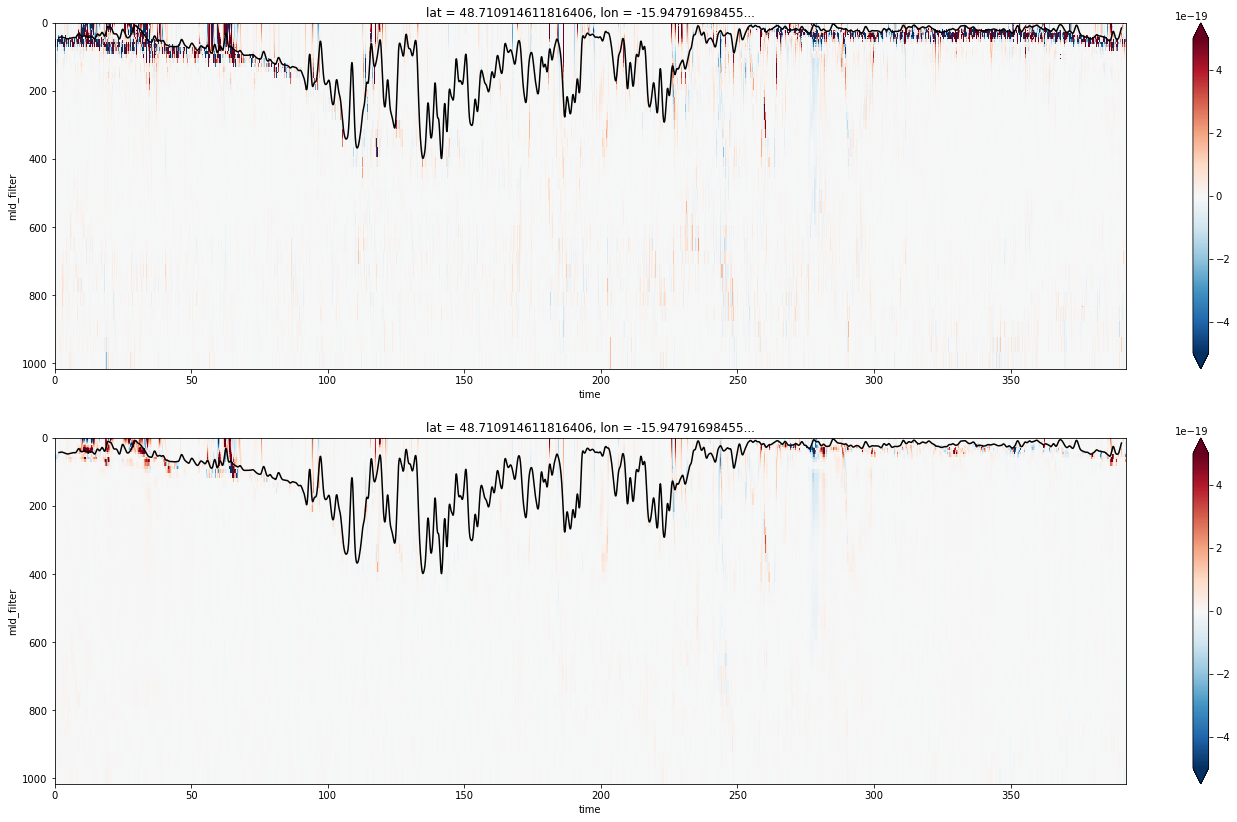

In [43]:
fig = plt.figure(figsize=(24,14))

plt.subplot(211)
Fs.isel(lat=100,lon=100).plot(x='time', y='depth', vmin=-5e-19, vmax=5e-19, cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

plt.subplot(212)
Fs_filter.isel(lat=100,lon=100).plot(x='time', y='depth', vmin=-5e-19, vmax=5e-19, cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

In [ ]:
cluster.close()